In [76]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [77]:
import os
import glob
import numpy as np
import pickle
import scipy.signal as signal
from scipy.stats import zscore
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import HistGradientBoostingClassifier
from sklearn.metrics import classification_report, accuracy_score
from feature_cleaning import extract_features_from_signal
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
import joblib
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler

In [78]:
def load_data(data_dir='data/'):
    """
    Load all .npy files from subdirectories (gesture labels) under data_dir.
    Assumes structure: data_dir/<gesture>/<gesture>_rep*.npy
    Returns:
        signals: list of raw signal arrays
        labels: list of corresponding labels (str)
    """
    signals = []
    labels = []
    for gesture_dir in os.listdir(data_dir):
        full_dir = os.path.join(data_dir, gesture_dir)
        if os.path.isdir(full_dir):
            for file in glob.glob(os.path.join(full_dir, '*.npy')):
                data = np.load(file).T
                if data.shape[0] != 7:
                    print(f"Skipping {file} with shape {data.shape}")
                    continue
                print(data.shape)
                new_data = np.concatenate((data[5],data[6]))
        
            
                signals.append(new_data)  # data is assumed to be a 2D array: samples x channels
                labels.append(gesture_dir)


    return signals, labels

In [79]:
signals, labels = load_data()

(7, 56400)
(7, 44700)
(7, 59900)


In [80]:
signal_chunck_size = 333
new_signals = []
new_labels = []
for label, signal in zip(labels, signals):

    signal1 = signal[:len(signal)//2]
    signal2 = signal[len(signal)//2:]

    for i in range(0, len(signal1), signal_chunck_size):
        if i + signal_chunck_size > len(signal1):
            i = len(signal1) - signal_chunck_size
        new_signal = np.concatenate((signal1[i:i+signal_chunck_size] ,signal2[i:i+signal_chunck_size]))

        features = extract_features_from_signal(new_signal)

        new_signals.append(features)
        new_labels.append(label)

In [81]:
new_signals[0], new_labels[-1]

(array([  50.27937562,   37.01293302,   67.        ,   74.        ,
        8739.4310565 ,   50.78125   ,   25.44045727,   21.07455075,
          36.        ,   92.        , 3013.01889913,   50.78125   ]),
 'repos')

In [82]:
df = pd.DataFrame(new_signals, columns=["rms1", "mav1", "zc1", "ssc1", "wl1", "dom_freq1","rms2", "mav2", "zc2", "ssc2", "wl2", "dom_freq2"])
df['label'] = new_labels 

label_mapping = {'open': "open", 'punch': "punch", 'repos': "rest"}
df['label'] = df['label'].map(label_mapping)

In [83]:
df.head()

,rms1,mav1,zc1,ssc1,wl1,dom_freq1,rms2,mav2,zc2,ssc2,wl2,dom_freq2,label
0,50.279376,37.012933,67.0,74.0,8739.431056,50.78125,25.440457,21.074551,36.0,92.0,3013.018899,50.78125,open
1,48.182673,35.867546,65.0,81.0,8882.648123,50.78125,25.108825,20.571979,56.0,103.0,3447.933425,50.78125,open
2,48.365290,36.245151,69.0,83.0,8523.205340,50.78125,24.744923,20.832921,45.0,100.0,3209.364583,50.78125,open
3,49.360352,37.495456,71.0,86.0,8750.240522,50.78125,26.840839,22.690374,50.0,101.0,3405.245992,50.78125,open
4,50.293637,39.279148,66.0,83.0,8758.618677,50.78125,27.577917,23.338871,36.0,99.0,3542.759402,50.78125,open


In [84]:
num_cols = df.select_dtypes(include=['number']).columns  # Select only numeric columns

scaler = StandardScaler()

df[num_cols] = scaler.fit_transform(df[num_cols])

In [85]:
joblib.dump(scaler, "scaler.pkl")

['scaler.pkl']

In [86]:
df.head()

,rms1,mav1,zc1,ssc1,wl1,dom_freq1,rms2,mav2,zc2,ssc2,wl2,dom_freq2,label
0,1.324181,1.209540,1.179436,-0.420524,1.332488,0.0,1.547885,1.406809,-0.628383,-0.668383,1.319257,-0.236424,open
1,1.205514,1.122644,1.016372,-0.070087,1.375872,0.0,1.501384,1.325884,0.642798,-0.124564,1.813044,-0.236424,open
2,1.215850,1.151292,1.342499,0.030037,1.266987,0.0,1.450360,1.367901,-0.056351,-0.272878,1.542181,-0.236424,open
3,1.272167,1.246147,1.505562,0.180225,1.335762,0.0,1.744241,1.666990,0.261444,-0.223440,1.764578,-0.236424,open
4,1.324988,1.381469,1.097904,0.030037,1.338300,0.0,1.847591,1.771412,-0.628383,-0.322316,1.920706,-0.236424,open


In [87]:
open_df = df[df['label'] == 'open']
repos_df = df[df['label'] == 'rest']
punch_df = df[df['label'] == 'punch']

In [88]:
def add_clusters(df,n_clusters=3):
    # Select features for clustering
    features = df.drop(columns=['label'])

    # Initialize the KMeans model
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)

    # Fit the model to the data
    kmeans.fit(features)

    # Add the cluster labels to the dataframe
    df['cluster'] = kmeans.labels_
    return df

In [89]:

def visualize_clusters(df):
    # Select features for PCA
    features = df.drop(columns=['label', 'cluster'])

    # Initialize the PCA model
    pca = PCA(n_components=2)

    # Fit and transform the data
    pca_result = pca.fit_transform(features)

    # Add the PCA results to the dataframe
    df['pca1'] = pca_result[:, 0]
    df['pca2'] = pca_result[:, 1]

    # Plot the PCA results
    plt.scatter(df['pca1'], df['pca2'], c=df['cluster'], cmap='viridis')
    plt.xlabel('PCA Component 1')
    plt.ylabel('PCA Component 2')
    plt.title('PCA of open_df Clusters')
    plt.show()

In [90]:
def get_cluster_mapping(df, verbose=False):
    data = {'0': np.array([]), '1': np.array([]), '2': np.array([])}
    classes = {'en_forme':-1, 'legere_fatigue':-1,'fatigue':-1}

    # Divide the dataframe into three equal parts
    third_length = len(df) // 3
    first_third = df[:third_length]
    second_third = df[third_length:2*third_length]
    last_third = df[2*third_length:]

    # Function to calculate the percentage of each cluster
    def calculate_cluster_percentage(df_part):
        cluster_counts = df_part['cluster'].value_counts(normalize=True) * 100

        for cluster in cluster_counts.keys():
            data[str(cluster)] = np.append(data[str(cluster)], cluster_counts[cluster])

        return cluster_counts

    # Calculate and print the percentage of each cluster in each third
    if verbose:
        print("First third cluster percentages:")
        print(calculate_cluster_percentage(first_third))

        print("\nSecond third cluster percentages:")
        print(calculate_cluster_percentage(second_third))

        print("\nLast third cluster percentages:")
        print(calculate_cluster_percentage(last_third))
    else:
        calculate_cluster_percentage(first_third)
        calculate_cluster_percentage(second_third)
        calculate_cluster_percentage(last_third)

            
    maximums = np.array([])
    for cluster in range(3):
        maximums = np.append(maximums, np.max(data[str(cluster)]))

    assigned = 0
    
    while assigned < 3:
        cluster_with_minimum_max = np.argmin(maximums)

        third_of_cluster_with_minimum_max = np.argmax(data[str(cluster_with_minimum_max)])



        if third_of_cluster_with_minimum_max == 0 and classes['en_forme'] == -1:
            classes['en_forme'] = cluster_with_minimum_max
            maximums[cluster_with_minimum_max] = np.inf
            del data[str(cluster_with_minimum_max)]
            assigned += 1
        elif third_of_cluster_with_minimum_max == 1 and classes['legere_fatigue'] == -1:
            classes['legere_fatigue'] = cluster_with_minimum_max
            maximums[cluster_with_minimum_max] = np.inf
            del data[str(cluster_with_minimum_max)]
            assigned += 1
        elif third_of_cluster_with_minimum_max == 2 and classes['fatigue'] == -1:
            classes['fatigue'] = cluster_with_minimum_max
            maximums[cluster_with_minimum_max] = np.inf
            del data[str(cluster_with_minimum_max)]
            assigned += 1
        else:
            data[str(cluster_with_minimum_max)] = np.delete(data[str(cluster_with_minimum_max)], third_of_cluster_with_minimum_max)
            for cluster in range(3):
                maximums = np.append(maximums, np.max(data[str(cluster)]))



    return dict(zip(classes.values(), classes.keys()))

# Creating tiredness clusters

c:\Users\walid\miniconda3\envs\amal\lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\walid\AppData\Local\Temp\ipykernel_7396\780576323.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['cluster'] = kmeans.labels_
C:\Users\walid\AppData\Local\Temp\ipykernel_7396\2036630061.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/inde

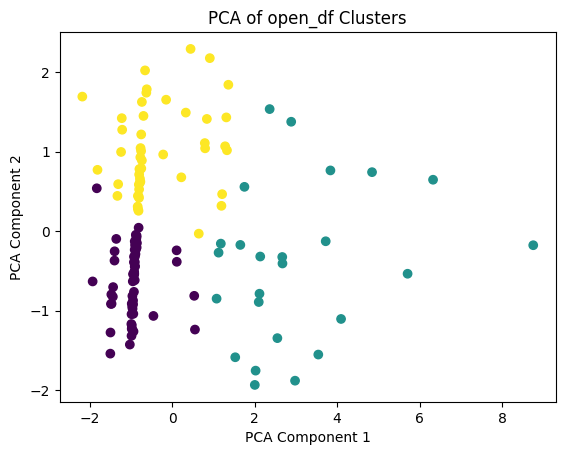

cluster_mapping={1: 'en_forme', 0: 'legere_fatigue', 2: 'fatigue'}


C:\Users\walid\AppData\Local\Temp\ipykernel_7396\3379811900.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  punch_df['cluster'] = punch_df['cluster'].map(cluster_mapping)


In [91]:
# 'punch' data
punch_df = add_clusters(punch_df, 3)
visualize_clusters(punch_df)
cluster_mapping = get_cluster_mapping(punch_df)
print(f"{cluster_mapping=}")

punch_df['cluster'] = punch_df['cluster'].map(cluster_mapping)

c:\Users\walid\miniconda3\envs\amal\lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\walid\AppData\Local\Temp\ipykernel_7396\780576323.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['cluster'] = kmeans.labels_
C:\Users\walid\AppData\Local\Temp\ipykernel_7396\2036630061.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/inde

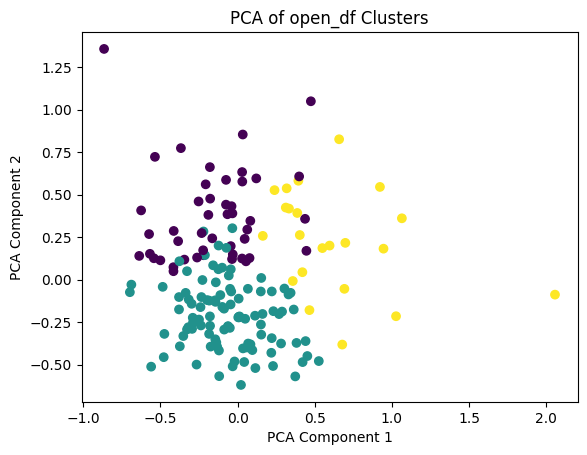

cluster_mapping={2: 'en_forme', 0: 'legere_fatigue', 1: 'fatigue'}


C:\Users\walid\AppData\Local\Temp\ipykernel_7396\779600370.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  open_df['cluster'] = open_df['cluster'].map(cluster_mapping)


In [92]:
# 'open' data
open_df = add_clusters(open_df, 3)
visualize_clusters(open_df)
cluster_mapping = get_cluster_mapping(open_df)
print(f"{cluster_mapping=}")

open_df['cluster'] = open_df['cluster'].map(cluster_mapping)

c:\Users\walid\miniconda3\envs\amal\lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\walid\AppData\Local\Temp\ipykernel_7396\780576323.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['cluster'] = kmeans.labels_
C:\Users\walid\AppData\Local\Temp\ipykernel_7396\2036630061.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/inde

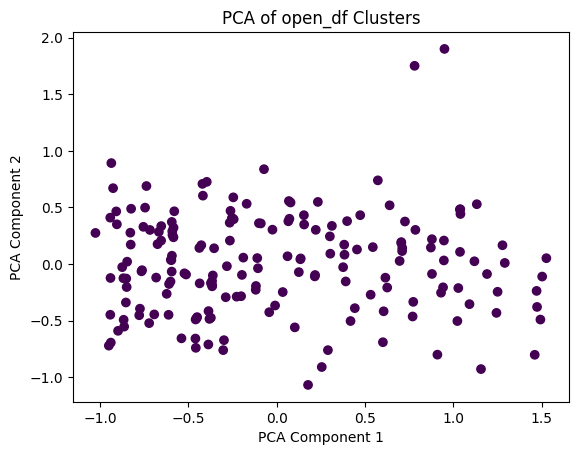

In [93]:
# 'repos' data
repos_df = add_clusters(repos_df, 1)
visualize_clusters(repos_df)

# Visualization of different movements data

       rms1      mav1       zc1      ssc1       wl1  dom_freq1      rms2  \
0  1.324181  1.209540  1.179436 -0.420524  1.332488        0.0  1.547885   
1  1.205514  1.122644  1.016372 -0.070087  1.375872        0.0  1.501384   
2  1.215850  1.151292  1.342499  0.030037  1.266987        0.0  1.450360   
3  1.272167  1.246147  1.505562  0.180225  1.335762        0.0  1.744241   
4  1.324988  1.381469  1.097904  0.030037  1.338300        0.0  1.847591   

       mav2       zc2      ssc2       wl2  dom_freq2 label      pca1      pca2  
0  1.406809 -0.628383 -0.668383  1.319257  -0.236424  open  3.616878  0.645664  
1  1.325884  0.642798 -0.124564  1.813044  -0.236424  open  3.091106  1.690281  
2  1.367901 -0.056351 -0.272878  1.542181  -0.236424  open  3.260510  1.374899  
3  1.666990  0.261444 -0.223440  1.764578  -0.236424  open  3.539836  1.815556  
4  1.771412 -0.628383 -0.322316  1.920706  -0.236424  open  3.899772  1.217547  


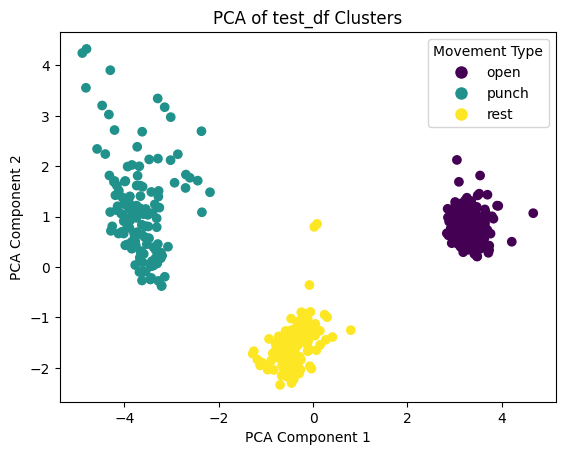

In [94]:
test_df = df.copy()


# Select features for PCA
features = test_df.drop(columns=['label'])

# Initialize the PCA model
pca = PCA(n_components=2)

# Fit and transform the data
pca_result = pca.fit_transform(features)

# Add the PCA results to the dataframe
test_df['pca1'] = pca_result[:, 0]
test_df['pca2'] = pca_result[:, 1]

print(test_df.head())

# Turn label column to integers
label_mapping = {label: idx for idx, label in enumerate(df['label'].unique())}
test_df['label'] = test_df['label'].map(label_mapping)


# Plot the clusters
scatter = plt.scatter(test_df['pca1'], test_df['pca2'], c=test_df['label'], cmap='viridis')

unique_labels = label_mapping.keys()  # Original labels
handles = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=scatter.cmap(scatter.norm(idx)), markersize=10)
           for idx in label_mapping.values()]

plt.legend(handles, unique_labels, title="Movement Type", loc="best")
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.title('PCA of test_df Clusters')
plt.show()

In [95]:
if not os.path.exists('models'):
    os.makedirs('models')

# Movement Classifier

In [96]:
df.head()

,rms1,mav1,zc1,ssc1,wl1,dom_freq1,rms2,mav2,zc2,ssc2,wl2,dom_freq2,label
0,1.324181,1.209540,1.179436,-0.420524,1.332488,0.0,1.547885,1.406809,-0.628383,-0.668383,1.319257,-0.236424,open
1,1.205514,1.122644,1.016372,-0.070087,1.375872,0.0,1.501384,1.325884,0.642798,-0.124564,1.813044,-0.236424,open
2,1.215850,1.151292,1.342499,0.030037,1.266987,0.0,1.450360,1.367901,-0.056351,-0.272878,1.542181,-0.236424,open
3,1.272167,1.246147,1.505562,0.180225,1.335762,0.0,1.744241,1.666990,0.261444,-0.223440,1.764578,-0.236424,open
4,1.324988,1.381469,1.097904,0.030037,1.338300,0.0,1.847591,1.771412,-0.628383,-0.322316,1.920706,-0.236424,open


Training Accuracy: 100.00%
Test Accuracy: 98.97%


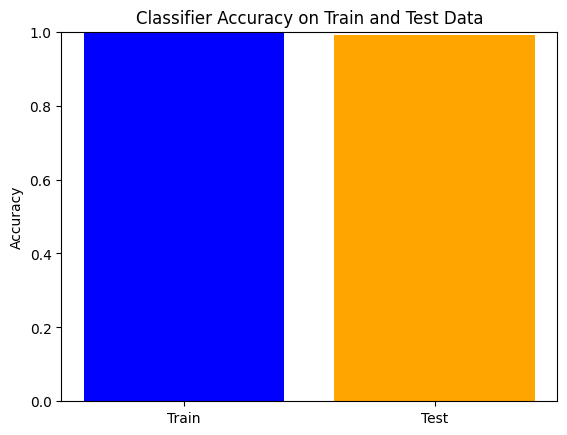

In [97]:
# Split the data into features and target
X = df.drop(columns=['label'])
y = df['label']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize the classifier
movement_classifier = HistGradientBoostingClassifier(random_state=42)

# Train the classifier
movement_classifier.fit(X_train, y_train)

# Predict on the training data
y_train_pred = movement_classifier.predict(X_train)

# Predict on the test data
y_test_pred = movement_classifier.predict(X_test)

# Calculate accuracy on the training data
train_accuracy = accuracy_score(y_train, y_train_pred)

# Calculate accuracy on the test data
test_accuracy = accuracy_score(y_test, y_test_pred)

# Print the accuracy
print(f"Training Accuracy: {train_accuracy * 100:.2f}%")
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")

# Visualize the accuracy
labels = ['Train', 'Test']
accuracies = [train_accuracy, test_accuracy]

plt.bar(labels, accuracies, color=['blue', 'orange'])
plt.ylabel('Accuracy')
plt.title('Classifier Accuracy on Train and Test Data')
plt.ylim(0, 1)
plt.show()

In [98]:
# Save the model to a file
with open('models/movement_classifier_model.pkl', 'wb') as file:
    pickle.dump(movement_classifier, file)
print("Model saved to 'models/movement_classifier_model.pkl'")


Model saved to 'models/movement_classifier_model.pkl'


# Tiredness Classifier

## Open hand movement

In [99]:
open_df.head()

,rms1,mav1,zc1,ssc1,wl1,dom_freq1,rms2,mav2,zc2,ssc2,wl2,dom_freq2,label,cluster,pca1,pca2
0,1.324181,1.209540,1.179436,-0.420524,1.332488,0.0,1.547885,1.406809,-0.628383,-0.668383,1.319257,-0.236424,open,fatigue,0.343381,-0.077533
1,1.205514,1.122644,1.016372,-0.070087,1.375872,0.0,1.501384,1.325884,0.642798,-0.124564,1.813044,-0.236424,open,en_forme,0.317890,0.537679
2,1.215850,1.151292,1.342499,0.030037,1.266987,0.0,1.450360,1.367901,-0.056351,-0.272878,1.542181,-0.236424,open,en_forme,0.239045,0.527040
3,1.272167,1.246147,1.505562,0.180225,1.335762,0.0,1.744241,1.666990,0.261444,-0.223440,1.764578,-0.236424,open,en_forme,0.657945,0.826513
4,1.324988,1.381469,1.097904,0.030037,1.338300,0.0,1.847591,1.771412,-0.628383,-0.322316,1.920706,-0.236424,open,en_forme,0.922443,0.545899


Training Accuracy: 100.00%
Test Accuracy: 94.12%


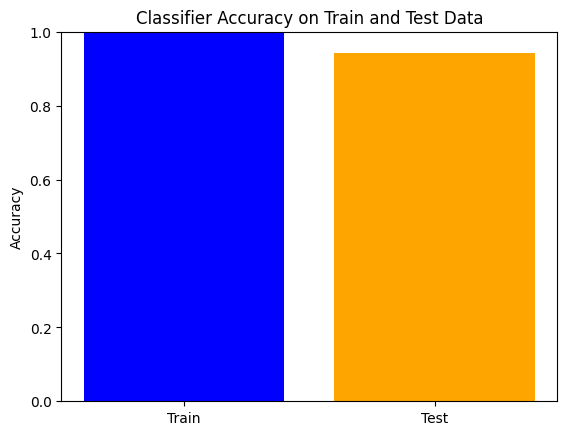

In [101]:
# Split the data into features and target
X = open_df.drop(columns=['label', 'cluster', 'pca1', 'pca2'])
y = open_df['cluster']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize the classifier
open_classifier = HistGradientBoostingClassifier(random_state=42)

# Train the classifier
open_classifier.fit(X_train, y_train)

# Predict on the training data
y_train_pred = open_classifier.predict(X_train)

# Predict on the test data
y_test_pred = open_classifier.predict(X_test)

# Calculate accuracy on the training data
train_accuracy = accuracy_score(y_train, y_train_pred)

# Calculate accuracy on the test data
test_accuracy = accuracy_score(y_test, y_test_pred)

# Print the accuracy
print(f"Training Accuracy: {train_accuracy * 100:.2f}%")
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")

# Visualize the accuracy
labels = ['Train', 'Test']
accuracies = [train_accuracy, test_accuracy]

plt.bar(labels, accuracies, color=['blue', 'orange'])
plt.ylabel('Accuracy')
plt.title('Classifier Accuracy on Train and Test Data')
plt.ylim(0, 1)
plt.show()

In [102]:
# Save the model to a file
with open('models/open_classifier_model.pkl', 'wb') as file:
    pickle.dump(open_classifier, file)
print("Model saved to 'models/open_classifier_model.pkl'")


Model saved to 'models/open_classifier_model.pkl'


## Punch Movement

In [103]:
punch_df.head()

,rms1,mav1,zc1,ssc1,wl1,dom_freq1,rms2,mav2,zc2,ssc2,wl2,dom_freq2,label,cluster,pca1,pca2
170,-1.214459,-1.260225,0.119524,2.833534,-1.064652,0.0,-1.346992,-1.381606,1.723303,1.754084,-1.118405,6.835472,punch,en_forme,6.326849,0.646940
171,-1.253862,-1.308426,0.608714,2.483097,-1.061948,0.0,-1.113043,-1.239117,1.723303,1.655208,-0.926978,-1.751831,punch,fatigue,-2.175760,1.692261
172,-1.243685,-1.301047,1.097904,2.483097,-1.072005,0.0,-1.176046,-1.272306,1.405507,0.963074,-0.941578,2.794388,punch,en_forme,2.365656,1.535353
173,-1.225769,-1.277703,-0.043540,2.633284,-1.079288,0.0,-1.100446,-1.295743,2.613130,2.347341,-0.877238,1.784118,punch,fatigue,1.330583,1.017716
174,-1.265825,-1.311119,-0.206603,2.983721,-1.084908,0.0,-1.100563,-1.164765,0.452121,0.913636,-0.865869,-0.236424,punch,fatigue,-0.731750,1.625159


Training Accuracy: 100.00%
Test Accuracy: 88.89%


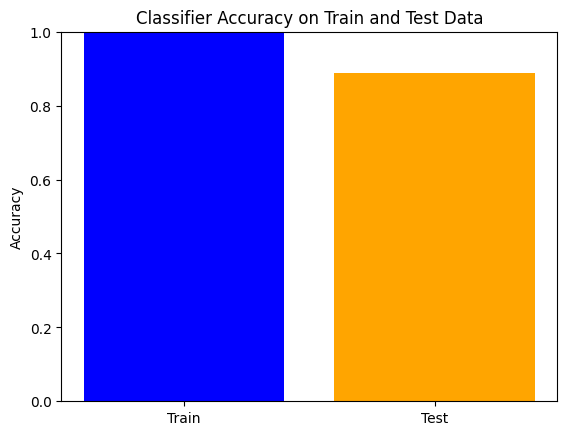

In [104]:
# Split the data into features and target
X = punch_df.drop(columns=['label', 'cluster', 'pca1', 'pca2'])
y = punch_df['cluster']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize the classifier
punch_classifier = HistGradientBoostingClassifier(random_state=42)

# Train the classifier
punch_classifier.fit(X_train, y_train)

# Predict on the training data
y_train_pred = punch_classifier.predict(X_train)

# Predict on the test data
y_test_pred = punch_classifier.predict(X_test)

# Calculate accuracy on the training data
train_accuracy = accuracy_score(y_train, y_train_pred)

# Calculate accuracy on the test data
test_accuracy = accuracy_score(y_test, y_test_pred)

# Print the accuracy
print(f"Training Accuracy: {train_accuracy * 100:.2f}%")
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")

# Visualize the accuracy
labels = ['Train', 'Test']
accuracies = [train_accuracy, test_accuracy]

plt.bar(labels, accuracies, color=['blue', 'orange'])
plt.ylabel('Accuracy')
plt.title('Classifier Accuracy on Train and Test Data')
plt.ylim(0, 1)
plt.show()

In [105]:
# Save the model to a file
with open('models/punch_classifier_model.pkl', 'wb') as file:
    pickle.dump(punch_classifier, file)
print("Model saved to 'models/punch_classifier_model.pkl'")


Model saved to 'models/punch_classifier_model.pkl'
